# Birka Fuel Oil calculation using Auto-ML

Fuel Oil flow calculation of the Birka-data, using different Machine Learning strategies.

In [1]:
%pylab inline
import pandas as pd
import sklearn
import time
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split


# Load the database

t1 = time.time()
print('Loading database ...')
df = pd.read_hdf('database/all_data_comp.h5','table')
print('Time to load database:', time.time()-t1)


Populating the interactive namespace from numpy and matplotlib
Loading database ...
Time to load database: 2.5204391479492188


# Feature selection FO-prediction data

Choose features for the model and export these to a new DataFrame. We first need to check the quality of the data, and see if if we have any NaN. In the first set we are going to use the volumetric flow meter for each fuel line as a predictor for the training.

As it is two fuel lines we create two individual models. Main engine 1,3 and Auxiliary Engine 1,3 are connected to one fuel line. 2/4 vice versa to the other one.

Lets start by using as few predictors as possible to speed up the model.



In [10]:
# Features and target for Eng 1/3

labels_1_3 = ['AE1 FUEL RACK POSIT:1742:mm:Average:900',
                'AE3 FUEL RACK POSIT:3742:mm:Average:900',
                'AE1 ENG SPEED:1745:RPM:Average:900',
                'AE3 ENG SPEED:3745:RPM:Average:900',
                'ME1 FUEL RACK POSIT:10005:%:Average:900',
                'ME3 FUEL RACK POSIT:30005:%:Average:900',
                'ME1 ENGINE SPEED:1364:rpm:Average:900',
                'ME3 ENGINE SPEED:3364:rpm:Average:900',
                'FO BOOST 1 CONSUMPT:6165:m3/h:Average:900']

# Features and target for Eng 2/4

labels_2_4 = ['AE2 FUEL RACK POSIT:2742:mm:Average:900',
                'AE4 FUEL RACK POSIT:4742:mm:Average:900',
                'AE2 ENG SPEED:2745:RPM:Average:900',
                'AE4 ENG SPEED:4745:RPM:Average:900',
                'ME2 FUEL RACK POSIT:20005:%:Average:900',
                'ME4 FUEL RACK POSIT:40005:%:Average:900',
                'ME2 ENGINE SPEED:2364:rpm:Average:900',
                'ME4 ENGINE SPEED:4364:rpm:Average:900',
             'FO BOOST 2 CONSUMPT:6166:m3/h:Average:900']


# Drop Nan from the DataFrame.

df_1_3 = df[labels_1_3].dropna()
df_2_4 = df[labels_2_4].dropna()


# Filter data
Some of the data may contain values which are wrong.

In [21]:
print('Features 1/3:')
print(df_1_3.min())
print(df_1_3.max())


print('Features 2/4:')
print(df_2_4.min())
print(df_2_4.max())

Features 1/3:
AE1 FUEL RACK POSIT:1742:mm:Average:900     -906.0
AE3 FUEL RACK POSIT:3742:mm:Average:900        0.0
AE1 ENG SPEED:1745:RPM:Average:900             0.0
AE3 ENG SPEED:3745:RPM:Average:900             0.0
ME1 FUEL RACK POSIT:10005:%:Average:900        0.0
ME3 FUEL RACK POSIT:30005:%:Average:900        0.0
ME1 ENGINE SPEED:1364:rpm:Average:900          0.0
ME3 ENGINE SPEED:3364:rpm:Average:900          0.0
FO BOOST 1 CONSUMPT:6165:m3/h:Average:900      0.0
dtype: float64
AE1 FUEL RACK POSIT:1742:mm:Average:900       48.533333
AE3 FUEL RACK POSIT:3742:mm:Average:900       47.000000
AE1 ENG SPEED:1745:RPM:Average:900           760.000000
AE3 ENG SPEED:3745:RPM:Average:900           756.200000
ME1 FUEL RACK POSIT:10005:%:Average:900       94.119102
ME3 FUEL RACK POSIT:30005:%:Average:900       90.287734
ME1 ENGINE SPEED:1364:rpm:Average:900        500.772504
ME3 ENGINE SPEED:3364:rpm:Average:900        502.962980
FO BOOST 1 CONSUMPT:6165:m3/h:Average:900      2.708800
dtype: f

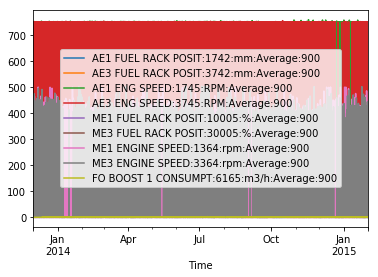

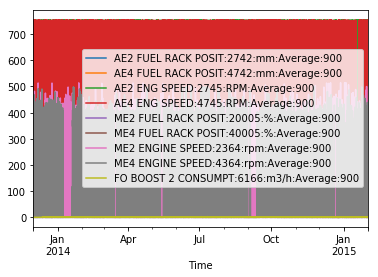

In [61]:
# All that is below zero is set to zero...

for n in list(df_1_3):
    df_1_3[n][(df_1_3[n] < 0)] = 0

for n in list(df_2_4):
    df_2_4[n][(df_2_4[n] < 0)] = 0
    
df_1_3[labels_1_3].plot()
df_2_4[labels_2_4].plot()

# Selecting features for volume flow meters and mass flow meters

The volume flow meters, which are installed for each engine side needs to be calibrated or trained, against the
mass flow meters. The mass flow meters are only updated once each day, and therefore we need to create a new
training set which has the sum of each days FO-flow.

The fuel oil can change in properties, both density and lower heating value depending on how the supplier and last bunkered date. This is information we do not have, so we have to see if we can find other indicators for this.

In [ ]:
'AE1 FO INLET PRESS:1603:Bar:Average:900'
'AE1 FO INLET TEMP:1605:  C:Average:900'

'AE2 FO INLET PRESS:2603:Bar:Average:900'
'AE2 FO INLET TEMP:2605:  C:Average:900'


'AE3 FO INLET PRESS:3603:Bar:Average:900'

'AE4 FO INLET PRESS:4603:Bar:Average:900'


'ME1 FO INLET PRESS:1301:bar:Average:900'
'ME1 FO INLET TEMP:1302:C:Average:900'

'ME2 FO INLET PRESS:2301:bar:Average:900'
'ME2 FO INLET TEMP:2302:C:Average:900'

'ME3 FO INLET PRESS:3301:bar:Average:900'
'ME3 FO INLET TEMP:3302:C:Average:900'

'ME4 FO INLET PRESS:4301:bar:Average:900'
'ME4 FO INLET TEMP:4302:C:Average:900'


                

FO VISCOSITY ME1/3:6141:-:Average:900
FO VISCOSITY ME2/4:6142:-:Average:900

FO TEMP AFTER ME1/3|:6137:C:Average:900
FO TEMP AFTER ME2/4|:6138:C:Average:900

HFO DAY TK T32CP TMP:6120:C:Average:900
HFO DAY TK T32CS TMP:6121:C:Average:900
                
                

In [13]:
df[labels_2_4].min()

AE2 FUEL RACK POSIT:2742:mm:Average:900     -1007.0
AE4 FUEL RACK POSIT:4742:mm:Average:900         0.0
AE2 ENG SPEED:2745:RPM:Average:900           -983.2
AE4 ENG SPEED:4745:RPM:Average:900              0.0
ME2 FUEL RACK POSIT:20005:%:Average:900         0.0
ME4 FUEL RACK POSIT:40005:%:Average:900         0.0
ME2 ENGINE SPEED:2364:rpm:Average:900           0.0
ME4 ENGINE SPEED:4364:rpm:Average:900           0.0
FO BOOST 2 CONSUMPT:6166:m3/h:Average:900       0.0
dtype: float64

# Feature selection 

In [ ]:
fo_1_3_total = df['FO_day_engine_1_3'].dropna()
fo_2_4_total = df['FO_day_engine_2_4'].dropna()


date_begin = '2014-02-01'
date_end = '2014-12-16'

# this gives the total in tonnes for each day.

# The dataset is not complete overlapping in time with data from both the mass-flow meters and the
# the rest of the data. So we have to manually filter out the time interval which we are interested in.
